In [ ]:
#@title Execution parameters
#@markdown Forms support many types of fields.

dataset_url = 'https://www.eeng.dcu.ie/~mcguinne/data/ee514/planetfour/planetfour.tar'  #@param {type: "string"}


## Planet four image classification

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import sklearn.metrics as metrics
import tqdm

from torch.utils.data import DataLoader
from torchvision.datasets.folder import pil_loader
from pathlib import Path
from PIL import Image

Change the device to "cpu" if you want to train on a CPU instead of a GPU.

In [ ]:
device = 'cuda'

## Dataset

Here we define a custom Dataset object for the Planet Four data. You can read more about this in the PyTorch documentation: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [ ]:
data_dir = Path('data')
!mkdir -p $data_dir
!curl -k $dataset_url > $data_dir/dataset.tar
!tar -C $data_dir/ -xvf $data_dir/dataset.tar
!rm $data_dir/dataset.tar
!mkdir -p checkpoints

curl: no URL specified!
curl: try 'curl --help' or 'curl --manual' for more information
tar: data/dataset.tar: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
rm: cannot remove 'data/dataset.tar': No such file or directory


In [ ]:
class PlanetFourDataset(object):
    def __init__(self, split='train', transform=None, loader=pil_loader):
        super().__init__()
        self.split = split
        self.base_dir = Path('data/planetfour')
        self.image_dir = self.base_dir / split
        self.labels_file = self.base_dir / (split + '.csv')
        self.labels_df = pd.read_csv(self.labels_file)
        self.transform = transform
        self.loader = loader
        
    def __getitem__(self, index):
        row = self.labels_df.iloc[index]
        filename = self.image_dir / (row.tile_id + '.jpg')
        fans = int(row.fans)
        blotches = int(row.blotches)
        image = self.loader(str(filename))
        if self.transform is not None:
            image = self.transform(image)
        return image, torch.tensor([fans, blotches], dtype=torch.float32)
    
    def __len__(self):
        return len(self.labels_df)

## Data augmentation

It is standard practice in deep learning to augment the training examples to prevent the network from overfitting. Here I use some standard augmentations such as randomly mirroring the images.

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))                  
])

valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) 
])

## Data loaders

In PyTorch, the data loaders take care of spinning up threads to load batches of data into memory from the dataset object.

In [ ]:
train_set = PlanetFourDataset('train', transform=train_transform)
valid_set = PlanetFourDataset('valid', transform=train_transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False)

FileNotFoundError: ignored

## Load a pretrained model

Here we'll use ResNet50 model that has been pretrained on ImageNet and replace the final layer with a new one suited to our problem.

In [ ]:
model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
model.fc = nn.Linear(2048, 2)
model.to(device);

[torch.Size([1000, 2048]), torch.Size([1000])]
[torch.Size([2, 2048]), torch.Size([2])]
torch.Size([64, 3, 7, 7])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 1, 1])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([256, 64, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([256, 64, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([64, 256, 1, 1])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([256, 64, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([64, 256, 1, 1])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([256, 64, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([128, 256, 1, 1])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([512, 128, 1, 1])
torch.Size([512])
torch.Size([512])
torch.Size([512, 256, 1, 1])
torc

## Loss

Images can contain fans, blotches, both, or neither. You could treat this as a four class softmax problem, or two binary classification problems. Here I take the latter approach and use a binary cross entropy loss. 

In [ ]:
criterion = nn.BCEWithLogitsLoss()

## Optimizer

Stochastic gradient descent with momentum

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

## Training and validation functions

In [ ]:
avg_train_losses = []
avg_valid_losses = []
valid_accuracies = []


def train_for_epoch(optimizer):
    model.train()

    train_losses = []

    for batch, target in tqdm.tqdm(train_loader):

        # data to GPU
        batch = batch.to(device)
        target = target.to(device)

        # reset optimizer
        optimizer.zero_grad()

        # forward pass
        predictions = model(batch)
        #breakpoint()

        # calculate loss
        loss = criterion(predictions, target)

        # backward pass
        loss.backward()

        # parameter update
        optimizer.step()

        # track loss
        train_losses.append(float(loss.item()))

    train_losses = np.array(train_losses)
    return train_losses


def validate():
    model.eval()

    valid_losses = []
    y_true, y_prob = [], []

    with torch.no_grad():
        for batch, target in valid_loader:

            # move data to the device
            batch = batch.to(device)
            target = target.to(device)

            # make predictions
            predictions = model(batch)

            # calculate loss
            loss = criterion(predictions, target)
            
            # logits -> probabilities
            torch.sigmoid_(predictions)

            # track losses and predictions
            valid_losses.append(float(loss.item()))
            y_true.extend(target.cpu().numpy())
            y_prob.extend(predictions.cpu().numpy())
            
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    y_pred = y_prob > 0.5
    valid_losses = np.array(valid_losses)

    # calculate validation accuracy from y_true and y_pred
    fan_accuracy = metrics.accuracy_score(y_true[:,0], y_pred[:,0])
    blotch_accuracy = metrics.accuracy_score(y_true[:,1], y_pred[:,1])
    exact_accuracy = np.all(y_true == y_pred, axis=1).mean()

    # calculate the mean validation loss
    valid_loss = valid_losses.mean()

    return valid_loss, fan_accuracy, blotch_accuracy, exact_accuracy


def train(epochs, first_epoch=1, model_name=''):
    for epoch in range(first_epoch, epochs+first_epoch):

        # train
        train_loss = train_for_epoch(optimizer)

        # validation
        valid_loss, fan_accuracy, blotch_accuracy, both_accuracy = validate()
        print(f'[{epoch:02d}] train loss: {train_loss.mean():0.04f}  '
              f'valid loss: {valid_loss:0.04f}  ',
              f'fan acc: {fan_accuracy:0.04f}  ',
              f'blotch acc: {blotch_accuracy:0.04f}  ',
              f'both acc: {both_accuracy:0.04f}'
        )
        
        # update learning curves
        avg_train_losses.append(train_loss.mean())
        avg_valid_losses.append(valid_loss)
        valid_accuracies.append((fan_accuracy, blotch_accuracy, both_accuracy))
        
        # save checkpoint
        torch.save(model, f'checkpoints/baseline_{model_name}_{epoch:03d}.pkl')

## Constant classifier accuracy

Evaluate how accurate would a $f(x) = \text{"most common class"}$ classifier be? 

In [ ]:
def constant_clf_accuracy():
    y_true, y_pred = [], []
    with torch.no_grad():
        for _, target in valid_loader:
            y_true.extend(target.cpu().numpy())
            y_pred.extend(np.ones((target.shape[0], 2), dtype=np.float32))
            
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
        
    # calculate validation accuracy from y_true and y_pred
    f = metrics.accuracy_score(y_true[:,0], y_pred[:,0])
    b = metrics.accuracy_score(y_true[:,1], y_pred[:,1])
    t = np.all(y_true == y_pred, axis=1).mean()
    print(f'fan: {f}  blotch: {b}  both: {t}')

In [ ]:
constant_clf_accuracy()

fan: 0.6218644702358667  blotch: 0.8083114938225384  both: 0.4399101460127293


## Train the model
Call the ``train(n)`` function to train for ``n`` epochs.

In [ ]:
n = 5
train(n, model_name='resnet50')

100%|██████████| 376/376 [01:09<00:00,  5.40it/s]


[01] train loss: 0.5404  valid loss: 0.4895   fan acc: 0.7274   blotch acc: 0.8117   both acc: 0.5717


100%|██████████| 376/376 [01:04<00:00,  5.81it/s]


[02] train loss: 0.4659  valid loss: 0.4468   fan acc: 0.7570   blotch acc: 0.8248   both acc: 0.6162


100%|██████████| 376/376 [01:04<00:00,  5.81it/s]


[03] train loss: 0.4292  valid loss: 0.4277   fan acc: 0.7701   blotch acc: 0.8248   both acc: 0.6252


100%|██████████| 376/376 [01:04<00:00,  5.86it/s]


[04] train loss: 0.4010  valid loss: 0.4156   fan acc: 0.7731   blotch acc: 0.8334   both acc: 0.6383


100%|██████████| 376/376 [01:03<00:00,  5.89it/s]


[05] train loss: 0.3790  valid loss: 0.4064   fan acc: 0.7825   blotch acc: 0.8341   both acc: 0.6451


Let's train the model for more epochs

In [ ]:
train(20, first_epoch=6, model_name='resnet50')

100%|██████████| 376/376 [01:04<00:00,  5.86it/s]


[06] train loss: 0.3638  valid loss: 0.4062   fan acc: 0.7866   blotch acc: 0.8330   both acc: 0.6503


100%|██████████| 376/376 [01:04<00:00,  5.84it/s]


[07] train loss: 0.3463  valid loss: 0.3979   fan acc: 0.7986   blotch acc: 0.8349   both acc: 0.6593


100%|██████████| 376/376 [01:04<00:00,  5.86it/s]


[08] train loss: 0.3316  valid loss: 0.3975   fan acc: 0.7963   blotch acc: 0.8311   both acc: 0.6593


100%|██████████| 376/376 [01:04<00:00,  5.85it/s]


[09] train loss: 0.3116  valid loss: 0.4029   fan acc: 0.7956   blotch acc: 0.8323   both acc: 0.6593


100%|██████████| 376/376 [01:04<00:00,  5.83it/s]


[10] train loss: 0.2964  valid loss: 0.3947   fan acc: 0.8042   blotch acc: 0.8360   both acc: 0.6664


100%|██████████| 376/376 [01:04<00:00,  5.85it/s]


[11] train loss: 0.2826  valid loss: 0.4127   fan acc: 0.7971   blotch acc: 0.8308   both acc: 0.6567


100%|██████████| 376/376 [01:03<00:00,  5.89it/s]


[12] train loss: 0.2665  valid loss: 0.4143   fan acc: 0.7937   blotch acc: 0.8383   both acc: 0.6586


100%|██████████| 376/376 [01:04<00:00,  5.83it/s]


[13] train loss: 0.2488  valid loss: 0.4313   fan acc: 0.8004   blotch acc: 0.8330   both acc: 0.6601


100%|██████████| 376/376 [01:04<00:00,  5.82it/s]


[14] train loss: 0.2320  valid loss: 0.4387   fan acc: 0.7941   blotch acc: 0.8282   both acc: 0.6529


100%|██████████| 376/376 [01:04<00:00,  5.83it/s]


[15] train loss: 0.2173  valid loss: 0.4568   fan acc: 0.7941   blotch acc: 0.8341   both acc: 0.6574


100%|██████████| 376/376 [01:04<00:00,  5.81it/s]


[16] train loss: 0.2002  valid loss: 0.4590   fan acc: 0.8031   blotch acc: 0.8297   both acc: 0.6627


100%|██████████| 376/376 [01:04<00:00,  5.84it/s]


[17] train loss: 0.1879  valid loss: 0.4794   fan acc: 0.7915   blotch acc: 0.8237   both acc: 0.6473


100%|██████████| 376/376 [01:04<00:00,  5.79it/s]


[18] train loss: 0.1767  valid loss: 0.4861   fan acc: 0.7975   blotch acc: 0.8300   both acc: 0.6544


100%|██████████| 376/376 [01:04<00:00,  5.82it/s]


[19] train loss: 0.1625  valid loss: 0.5024   fan acc: 0.8012   blotch acc: 0.8326   both acc: 0.6630


100%|██████████| 376/376 [01:04<00:00,  5.83it/s]


[20] train loss: 0.1469  valid loss: 0.5138   fan acc: 0.8053   blotch acc: 0.8259   both acc: 0.6627


100%|██████████| 376/376 [01:04<00:00,  5.80it/s]


[21] train loss: 0.1378  valid loss: 0.5317   fan acc: 0.8008   blotch acc: 0.8345   both acc: 0.6645


100%|██████████| 376/376 [01:04<00:00,  5.84it/s]


[22] train loss: 0.1249  valid loss: 0.5548   fan acc: 0.8012   blotch acc: 0.8237   both acc: 0.6548


100%|██████████| 376/376 [01:04<00:00,  5.82it/s]


[23] train loss: 0.1173  valid loss: 0.5764   fan acc: 0.7885   blotch acc: 0.8237   both acc: 0.6458


100%|██████████| 376/376 [01:04<00:00,  5.86it/s]


[24] train loss: 0.1078  valid loss: 0.5834   fan acc: 0.8023   blotch acc: 0.8289   both acc: 0.6619


100%|██████████| 376/376 [01:04<00:00,  5.84it/s]


[25] train loss: 0.0977  valid loss: 0.5976   fan acc: 0.7990   blotch acc: 0.8158   both acc: 0.6469


Let's plot the training and testing losses

In [ ]:
def plot_losses(classifier):
  plt.plot(avg_train_losses, label='Average training losses')
  plt.plot(avg_valid_losses, label='Average valid losses')

  plt.legend()
  plt.title(f'Losses for {classifier}')
  plt.show()

def plot_accuracies(classifier):
  plt.plot([v[0] for v in valid_accuracies], label='Fan accuracies')
  plt.plot([v[1] for v in valid_accuracies], label='Bloth accuracies')
  plt.plot([v[2] for v in valid_accuracies], label='Both accuracies')

  plt.legend()
  plt.title(f'Accuracies for {classifier}')
  plt.show()

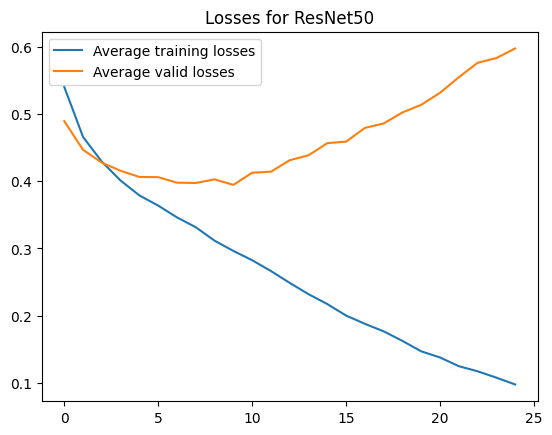

In [ ]:
plot_losses('ResNet50')

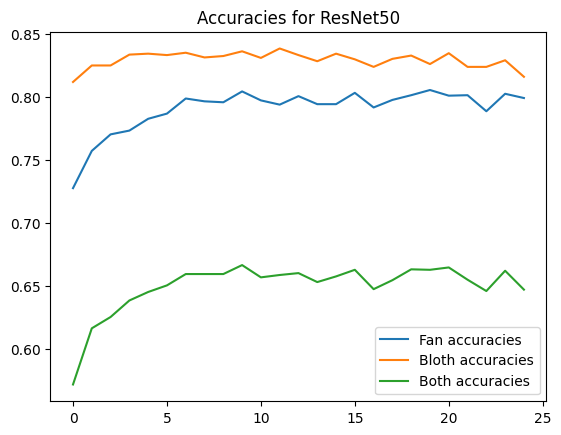

In [ ]:
plot_accuracies('ResNet50')

# Experiments

In [ ]:
resnet = model
resnet_avg_train_losses = avg_train_losses
resnet_avg_valid_losses = avg_valid_losses
resnet_valid_accuracies = valid_accuracies

Let's test with ConvNeXt

In [ ]:
avg_train_losses = []
avg_valid_losses = []
valid_accuracies = []

model = models.convnext_base(num_classes=2)
model.to(device);

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

train(20, model_name='convnext_base')

100%|██████████| 376/376 [02:18<00:00,  2.71it/s]


[01] train loss: 0.5945  valid loss: 0.6010   fan acc: 0.5470   blotch acc: 0.7960   both acc: 0.4306


100%|██████████| 376/376 [02:19<00:00,  2.70it/s]


[02] train loss: 0.5842  valid loss: 0.5766   fan acc: 0.6387   blotch acc: 0.8087   both acc: 0.4650


100%|██████████| 376/376 [02:19<00:00,  2.70it/s]


[03] train loss: 0.5780  valid loss: 0.5678   fan acc: 0.6222   blotch acc: 0.8083   both acc: 0.4414


100%|██████████| 376/376 [02:19<00:00,  2.70it/s]


[04] train loss: 0.5777  valid loss: 0.5750   fan acc: 0.6129   blotch acc: 0.8083   both acc: 0.4526


100%|██████████| 376/376 [02:19<00:00,  2.69it/s]


[05] train loss: 0.5768  valid loss: 0.5720   fan acc: 0.6305   blotch acc: 0.8083   both acc: 0.4511


100%|██████████| 376/376 [02:20<00:00,  2.68it/s]


[06] train loss: 0.5751  valid loss: 0.5712   fan acc: 0.6264   blotch acc: 0.8083   both acc: 0.4452


100%|██████████| 376/376 [02:20<00:00,  2.67it/s]


[07] train loss: 0.5745  valid loss: 0.6148   fan acc: 0.4365   blotch acc: 0.8083   both acc: 0.3823


100%|██████████| 376/376 [02:20<00:00,  2.68it/s]


[08] train loss: 0.5741  valid loss: 0.5714   fan acc: 0.6301   blotch acc: 0.8079   both acc: 0.4601


100%|██████████| 376/376 [02:19<00:00,  2.69it/s]


[09] train loss: 0.5747  valid loss: 0.5724   fan acc: 0.6275   blotch acc: 0.8083   both acc: 0.4478


100%|██████████| 376/376 [02:19<00:00,  2.69it/s]


[10] train loss: 0.5739  valid loss: 0.5733   fan acc: 0.6312   blotch acc: 0.8023   both acc: 0.4560


100%|██████████| 376/376 [02:19<00:00,  2.69it/s]


[11] train loss: 0.5725  valid loss: 0.5716   fan acc: 0.6234   blotch acc: 0.8083   both acc: 0.4511


100%|██████████| 376/376 [02:19<00:00,  2.69it/s]


[12] train loss: 0.5709  valid loss: 0.5729   fan acc: 0.6267   blotch acc: 0.8076   both acc: 0.4545


100%|██████████| 376/376 [02:19<00:00,  2.69it/s]


[13] train loss: 0.5729  valid loss: 0.5753   fan acc: 0.6200   blotch acc: 0.8083   both acc: 0.4485


100%|██████████| 376/376 [02:19<00:00,  2.69it/s]


[14] train loss: 0.5721  valid loss: 0.5789   fan acc: 0.5747   blotch acc: 0.8064   both acc: 0.4343


100%|██████████| 376/376 [02:19<00:00,  2.69it/s]


[15] train loss: 0.5712  valid loss: 0.5732   fan acc: 0.6174   blotch acc: 0.8083   both acc: 0.4489


100%|██████████| 376/376 [02:21<00:00,  2.65it/s]


[16] train loss: 0.5690  valid loss: 0.5747   fan acc: 0.6058   blotch acc: 0.8072   both acc: 0.4448


100%|██████████| 376/376 [02:19<00:00,  2.69it/s]


[17] train loss: 0.5699  valid loss: 0.5700   fan acc: 0.6226   blotch acc: 0.8083   both acc: 0.4433


100%|██████████| 376/376 [02:20<00:00,  2.67it/s]


[18] train loss: 0.5686  valid loss: 0.5869   fan acc: 0.5459   blotch acc: 0.8079   both acc: 0.4332


100%|██████████| 376/376 [02:20<00:00,  2.68it/s]


[19] train loss: 0.5709  valid loss: 0.5682   fan acc: 0.6264   blotch acc: 0.8083   both acc: 0.4500


100%|██████████| 376/376 [02:19<00:00,  2.69it/s]


[20] train loss: 0.5676  valid loss: 0.5899   fan acc: 0.5133   blotch acc: 0.8072   both acc: 0.4201


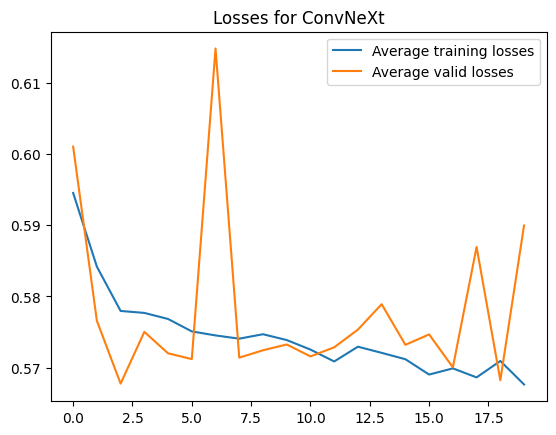

In [ ]:
plot_losses('ConvNeXt')

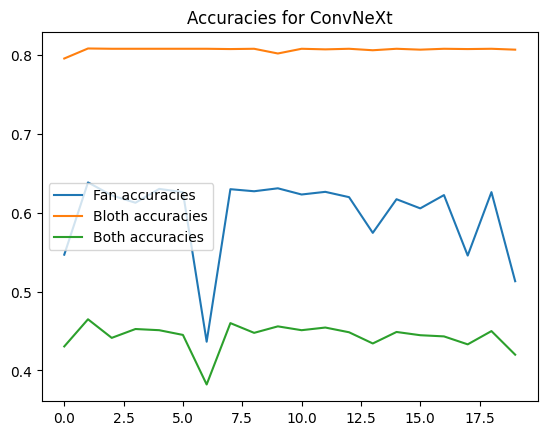

In [ ]:
plot_accuracies('ConvNeXt')

Let's see if AlexNet does any better

In [ ]:
convnext = model
convnext_avg_train_losses = avg_train_losses
convnext_avg_valid_losses = avg_valid_losses
convnext_valid_accuracies = valid_accuracies

In [ ]:
avg_train_losses = []
avg_valid_losses = []
valid_accuracies = []

model = models.alexnet(num_classes=2)
model.to(device);

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

train(20, model_name='alexnet')

100%|██████████| 376/376 [00:39<00:00,  9.47it/s]


[01] train loss: 0.6295  valid loss: 0.5833   fan acc: 0.6219   blotch acc: 0.8083   both acc: 0.4399


100%|██████████| 376/376 [00:36<00:00, 10.44it/s]


[02] train loss: 0.5855  valid loss: 0.5778   fan acc: 0.6219   blotch acc: 0.8083   both acc: 0.4399


100%|██████████| 376/376 [00:36<00:00, 10.31it/s]


[03] train loss: 0.5834  valid loss: 0.5756   fan acc: 0.6219   blotch acc: 0.8083   both acc: 0.4399


100%|██████████| 376/376 [00:35<00:00, 10.55it/s]


[04] train loss: 0.5816  valid loss: 0.5745   fan acc: 0.6219   blotch acc: 0.8083   both acc: 0.4399


100%|██████████| 376/376 [00:35<00:00, 10.66it/s]


[05] train loss: 0.5804  valid loss: 0.5732   fan acc: 0.6219   blotch acc: 0.8083   both acc: 0.4399


100%|██████████| 376/376 [00:35<00:00, 10.55it/s]


[06] train loss: 0.5792  valid loss: 0.5729   fan acc: 0.6219   blotch acc: 0.8083   both acc: 0.4399


100%|██████████| 376/376 [00:36<00:00, 10.20it/s]


[07] train loss: 0.5778  valid loss: 0.5702   fan acc: 0.6219   blotch acc: 0.8083   both acc: 0.4399


100%|██████████| 376/376 [00:35<00:00, 10.61it/s]


[08] train loss: 0.5763  valid loss: 0.5708   fan acc: 0.6219   blotch acc: 0.8083   both acc: 0.4399


100%|██████████| 376/376 [00:35<00:00, 10.74it/s]


[09] train loss: 0.5746  valid loss: 0.5671   fan acc: 0.6237   blotch acc: 0.8083   both acc: 0.4414


100%|██████████| 376/376 [00:35<00:00, 10.53it/s]


[10] train loss: 0.5726  valid loss: 0.5646   fan acc: 0.6455   blotch acc: 0.8083   both acc: 0.4620


100%|██████████| 376/376 [00:35<00:00, 10.61it/s]


[11] train loss: 0.5701  valid loss: 0.5620   fan acc: 0.6552   blotch acc: 0.8083   both acc: 0.4736


100%|██████████| 376/376 [00:36<00:00, 10.39it/s]


[12] train loss: 0.5672  valid loss: 0.5609   fan acc: 0.6672   blotch acc: 0.8083   both acc: 0.4931


100%|██████████| 376/376 [00:35<00:00, 10.55it/s]


[13] train loss: 0.5638  valid loss: 0.5558   fan acc: 0.6571   blotch acc: 0.8083   both acc: 0.4882


100%|██████████| 376/376 [00:34<00:00, 10.83it/s]


[14] train loss: 0.5602  valid loss: 0.5528   fan acc: 0.6638   blotch acc: 0.8083   both acc: 0.4991


100%|██████████| 376/376 [00:35<00:00, 10.61it/s]


[15] train loss: 0.5567  valid loss: 0.5528   fan acc: 0.6612   blotch acc: 0.8083   both acc: 0.4957


100%|██████████| 376/376 [00:35<00:00, 10.62it/s]


[16] train loss: 0.5544  valid loss: 0.5510   fan acc: 0.6660   blotch acc: 0.8083   both acc: 0.5032


100%|██████████| 376/376 [00:35<00:00, 10.61it/s]


[17] train loss: 0.5510  valid loss: 0.5458   fan acc: 0.6956   blotch acc: 0.8083   both acc: 0.5470


100%|██████████| 376/376 [00:36<00:00, 10.39it/s]


[18] train loss: 0.5480  valid loss: 0.5466   fan acc: 0.6885   blotch acc: 0.8083   both acc: 0.5328


100%|██████████| 376/376 [00:35<00:00, 10.72it/s]


[19] train loss: 0.5459  valid loss: 0.5402   fan acc: 0.6975   blotch acc: 0.8083   both acc: 0.5410


100%|██████████| 376/376 [00:34<00:00, 10.81it/s]


[20] train loss: 0.5429  valid loss: 0.5432   fan acc: 0.6874   blotch acc: 0.8083   both acc: 0.5474


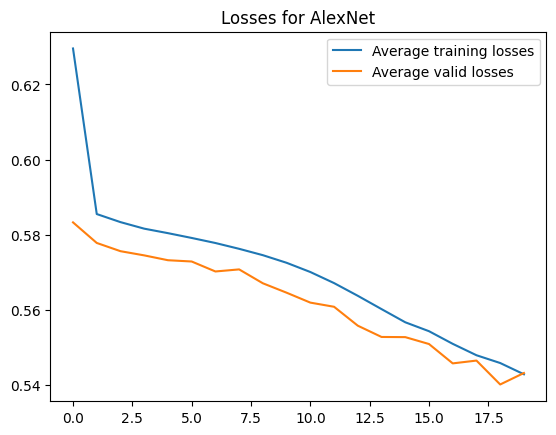

In [ ]:
plot_losses('AlexNet')

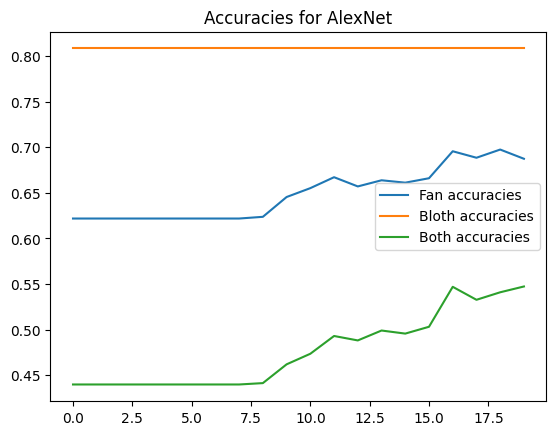

In [ ]:
plot_accuracies('AlexNet')

We can see that amongst these 3 models, resnet50 is the one with better performance.